# generic scikit-learn classifier

run any scikit-learn compatible classifier or list of classifiers

## steps
1. **generate a scikit-learn model configuration** using the `model_pkg_class` parameter
   * input a package and class name, for example, `sklearn.linear_model.LogisticRegression`  
   * mlrun will find the class and instantiate a copy using default parameters  
   * You can modify both the model class instantiator and the fit methods  (other functions could be similarly modified)
2. **get a sample of data** from a data source
   * select all rows using -1
   * select a random sample of rows using a negative integer
   * select consecutive rows using a positive integer
3. **split the data** into train, validation, and test sets 
   * the test set is saved as an artifact and never seen again until testing
   * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)
4. **train the model** using xgboost in one of its flavours (dask, gpu, mpi...)
5. **pickle / serialize the model**
   * models can be pickled or saved as json (a newer xgboost format)
6. **evaluate the model**
   * a custom evaluator can be provided, see function doc for details

In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import os

from cloudpickle import dumps, load, dump

from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics

from typing import List
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact

import mlutils
from mlutils import (get_sample, get_splits,
                     gen_sklearn_model, create_class,
                     eval_class_model, log_model)

def train_model(
    context: MLClientCtx,
    model_pkg_class: str,
    dataset: DataItem,
    label_column: str = "labels",
    encode_cols: List[str] = [],
    sample: int = -1,
    test_size: float = 0.30,
    train_val_split: float = 0.75,
    test_set_key: str = "test_set",
    model_evaluator = None,
    models_dest: str = "",
    plots_dest: str = "",
    file_ext: str = "parquet",
    model_pkg_file: str = "",
    random_state: int = 1,
) -> None:
    """train a classifier
    
    An optional cutom model evaluator can be supplied that should have the signature:
    `my_custom_evaluator(context, xvalid, yvalid, model)` and return a dictionary of 
    scalar "results", a "plots" keys with a list of PlotArtifacts, and 
    and "tables" key containing a returned list of TableArtifacts.
    
    :param context:           the function context
    :param model_pkg_class:   the model to train, e.g, "sklearn.neural_networks.MLPClassifier", 
                              or json model config
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param test_size:         (0.05) test set size
    :param train_val_split:   (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param test_set_key:      key of held out data in artifact store
    :param model_evaluator:   (None) a custom model evaluator can be specified
    :param models_dest:       ("") models subfolder on artifact path
    :param plots_dest:        ("") plot subfolder on artifact path
    :param file_ext:          ("parquet") format for test_set_key hold out data
    :param random_state:      (1) sklearn rng seed

    """
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train, validate, and test sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, 1-train_val_split, random_state)
    
    # set aside some test data
    context.log_dataset(test_set_key, 
                        df=pd.concat([xtest, ytest.to_frame()], axis=1),
                        format=file_ext, index=False, 
                        labels={"data-type": "held-out"})

    # generate a model configuration and add CLASS and FIT params:
    model_config = gen_sklearn_model(model_pkg_class,
                                     context.parameters.items())

    # update FIT params with features and labels:
    model_config["FIT"].update({"X": xtrain,
                                "y": ytrain.values})
    
    # generate a scikit-learn class:
    ClassifierClass = create_class(model_config["META"]["class"])
    
    # instantiate the class with our updated CLASS params:
    model = ClassifierClass(**model_config["CLASS"])
    
    # and run `fit` with our updated FIT params:
    model.fit(**model_config["FIT"])
    
    # evaluate model:
    if model_evaluator:
        eval_metrics = model_evaluator(context, xvalid, yvalid, model)
    else:
        eval_metrics = eval_class_model(context, xvalid, yvalid, model)
        
    # log it all:
    log_model(context, dumps(model), eval_metrics, plots_dest, models_dest)

In [3]:
# nuclio: end-code

### sklearn trainer setup

the following task paramaters are common to all runs

In [4]:
task_params = {
    "name" : "task sklearn classifier",
    "params" : {
        "sample"             : -1,
        "test_size"          : 0.30,
        "train_val_split"    : 0.75,
        "random_state"       : 1,
        "n_jobs"             : -1,
        "models_dest"        : 'sklearn-clfmodel'}}

models = [
    "sklearn.ensemble.RandomForestClassifier", 
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier"
]

### set model parameters and run locally

* loop over a list of candidate models, update the task and run a local trainer for that model  
* optionally customize some parameters for each model
* accumulate the resulting artifacts in a list of dicts for debugging and testing purposes  

please note that the following parameters have been chosen without regard to optimization and model tuning

In [5]:
#dataset = "clf-k3-m24-n100k-imb.csv" # 3 class 24 feats 100k obs imbalanced
#dataset = "clf-k2-m24-n10k-bal.csv" # 2 class 24 feats 100k obs balanced
dataset = "sklearn/iris_dataset.csv"
# choose from breast_cancer, iris, wine, higgs...

[mlrun] 2020-05-27 01:11:11,920 starting run sklearn_ensemble_RandomForestClassifier uid=58f615b4d5be4529a4896ee562fdaa79  -> http://mlrun-api:8080
[mlrun] 2020-05-27 01:11:12,020 log artifact test_set at /User/artifacts/test_set.parquet, size: 4558, db: Y
MULTICLASS True
[mlrun] 2020-05-27 01:11:12,621 log artifact confusion-matrix-normalized at /User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-27 01:11:12,665 log artifact feature-importances at /User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/feature-importances.html, size: 10278, db: Y
[mlrun] 2020-05-27 01:11:12,687 log artifact precision-recall-multiclass at /User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/precision-recall-multiclass.html, size: 1766, db: Y
[mlrun] 2020-05-27 01:11:12,755 log artifact roc-multiclass at /User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/roc-multiclass.html, size: 20481, db: Y
[mlrun]

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...62fdaa79,0,May 27 01:11:11,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-f9d6597fd-ns9cj,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelmodels_dest=sklearn/sklearn.ensemble.RandomForestClassifierCLASS_max_depth=2,test-accuracy=0.8846153846153846test-error=0.11538461538461539auc-micro=0.9911242603550295auc-weighted=0.9978632478632478f1-score=0.8564102564102565precision_score=0.8888888888888888recall_score=0.875,test_setconfusion-matrix-normalizedfeature-importancesprecision-recall-multiclassroc-multiclassfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 58f615b4d5be4529a4896ee562fdaa79 --project default , !mlrun logs 58f615b4d5be4529a4896ee562fdaa79 --project default
[mlrun] 2020-05-27 01:11:12,837 run executed, status=completed
[mlrun] 2020-05-27 01:11:12,843 starting run sklearn_linear_model_LogisticRegression uid=5d55d34d20a84e36941e35a288e0fe69  -> http://mlrun-api:8080
[mlrun] 2020-05-27 01:11:12,919 log artifact test_set at /User/artifacts/test_set.parquet, size: 4558, db: Y
MULTICLASS True
[mlrun] 2020-05-27 01:11:13,111 log artifact confusion-matrix-normalized at /User/artifacts/plots/sklearn_linear_model_LogisticRegression/confusion-matrix-normalized.html, size: 10726, db: Y
[mlrun] 2020-05-27 01:11:13,136 log artifact precision-recall-multiclass at /User/artifacts/plots/sklearn_linear_model_LogisticRegression/precision-recall-multiclass.html, size: 1766, db: Y
[mlrun] 2020-05-27 01:11:13,204 log artifact roc-multiclass at /User/artifacts/plots/sklearn_linear_

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...88e0fe69,0,May 27 01:11:12,completed,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=handlerowner=adminhost=jupyter-f9d6597fd-ns9cj,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelmodels_dest=sklearn/sklearn.linear_model.LogisticRegressionCLASS_solver=liblinear,test-accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,test_setconfusion-matrix-normalizedprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 5d55d34d20a84e36941e35a288e0fe69 --project default , !mlrun logs 5d55d34d20a84e36941e35a288e0fe69 --project default
[mlrun] 2020-05-27 01:11:13,267 run executed, status=completed
[mlrun] 2020-05-27 01:11:13,273 starting run sklearn_ensemble_AdaBoostClassifier uid=b76ed4392fd94ab9891f08adabb925f3  -> http://mlrun-api:8080
[mlrun] 2020-05-27 01:11:13,354 log artifact test_set at /User/artifacts/test_set.parquet, size: 4558, db: Y
MULTICLASS True
[mlrun] 2020-05-27 01:11:14,011 log artifact confusion-matrix-normalized at /User/artifacts/plots/sklearn_ensemble_AdaBoostClassifier/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-27 01:11:14,058 log artifact feature-importances at /User/artifacts/plots/sklearn_ensemble_AdaBoostClassifier/feature-importances.html, size: 10506, db: Y
[mlrun] 2020-05-27 01:11:14,078 log artifact precision-recall-multiclass at /User/artifacts/plots/sklearn_ensemble_AdaBoostClass

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...abb925f3,0,May 27 01:11:13,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-f9d6597fd-ns9cj,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelmodels_dest=sklearn/sklearn.ensemble.AdaBoostClassifierCLASS_n_estimators=200CLASS_learning_rate=1.2,test-accuracy=0.8461538461538461test-error=0.15384615384615385auc-micro=0.8757396449704142auc-weighted=0.9512820512820513f1-score=0.8055555555555555precision_score=0.8666666666666667recall_score=0.8333333333333334,test_setconfusion-matrix-normalizedfeature-importancesprecision-recall-multiclassroc-multiclassfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run b76ed4392fd94ab9891f08adabb925f3 --project default , !mlrun logs b76ed4392fd94ab9891f08adabb925f3 --project default
[mlrun] 2020-05-27 01:11:14,229 run executed, status=completed


<Figure size 432x288 with 0 Axes>

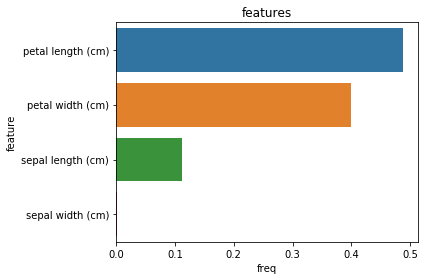

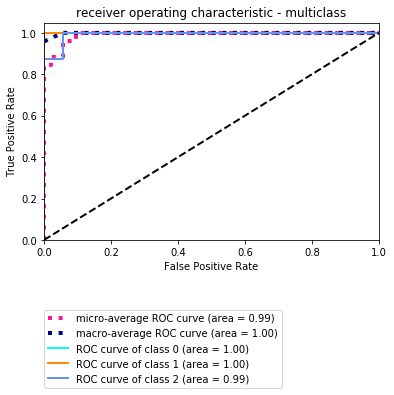

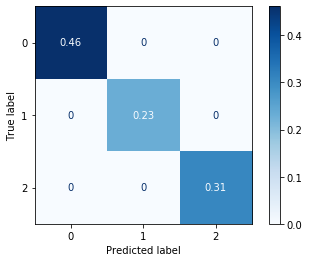

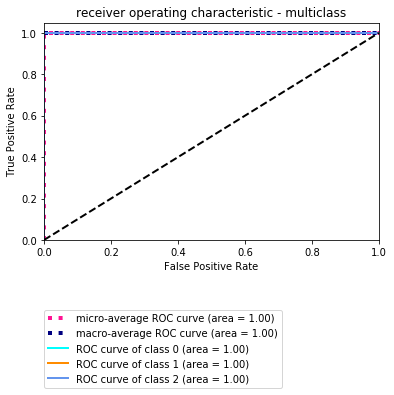

<Figure size 432x288 with 0 Axes>

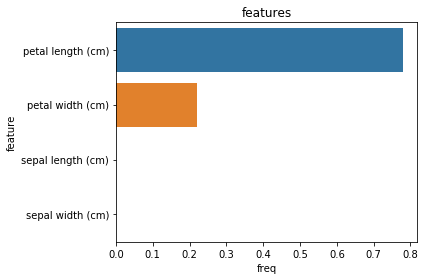

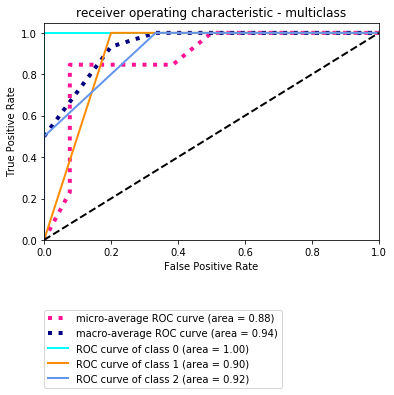

In [17]:
from mlrun import run_local, NewTask, mlconf

outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {"params":
         { "model_pkg_class" : model,
           "label_column"    : "label",
           "models_dest"     : f'sklearn/{model}'}})
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 2})

    if "LogisticRegression" in model:
        # use liblinear for small test set
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        # set max estimators below default, use weird learning rate
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 1.2
                                   })
    
    name = model.replace('.', '_')
    output = run_local(
        NewTask(**task_copy),
        handler=train_model,
        name=name,
        inputs={
            #"dataset"  : "https://raw.githubusercontent.com/yjb-ds/testdata/master/data/clf-k2-m24-n100k-bal.zip"
            "dataset"  : mlconf.artifact_path + f"/{dataset}"
        })
    outputs.append({name: output.outputs})

In [7]:
outputs

[{'sklearn_ensemble_RandomForestClassifier': {'test-accuracy': 0.9230769230769231,
   'test-error': 0.07692307692307693,
   'auc-micro': 0.992603550295858,
   'auc-weighted': 1.0,
   'f1-score': 0.9047619047619048,
   'precision_score': 0.9166666666666666,
   'recall_score': 0.9166666666666666,
   'test_set': 'store://default/sklearn_ensemble_RandomForestClassifier_test_set#e7a2861b9cd948eb8222459ca20557e8',
   'confusion-matrix-normalized': '/User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/confusion-matrix-normalized.html',
   'feature-importances': '/User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/feature-importances.html',
   'precision-recall-multiclass': '/User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/precision-recall-multiclass.html',
   'roc-multiclass': '/User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/roc-multiclass.html',
   'feature-importances-tbl': '/User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/roc-multi

### run remotely

In [8]:
from mlutils import create_function

fn_params = {
    "name"            : "sklearn_classifier",
    "project"         : "functions",
    "default_handler" : "train_model",
    "desc"            : "train any classifier using scikit-learn's API",
    "categories"      : ["ml", "training"],
    "labels"          : {"author": "yjb", "framework": "sklearn"},
    "kind"            : "job",
    "image"           : "yjbds/ml-models",
    "tag"             : mlconf.images_tag,
}

In [9]:
fn = create_function(fn_params, path='.')

[mlrun] 2020-05-27 01:06:35,334 function spec saved to path: ./function.yaml


In [10]:
outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {"params":
         {"model_pkg_class":model, 
          "label_column" : "label",
          "models_dest" : f'sklearn/{model}'}})

    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 2})

    if "LogisticRegression" in model:
        # use liblinear for small test set
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        # set max estimators below default, use weird learning rate
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 1.2})

    name = model.replace('.', '_')
    fn.run(
        NewTask(**task_copy),
        name=name,
        inputs={
            "dataset"  : mlconf.artifact_path + f"/{dataset}"
        })
    outputs.append({name: output.outputs})

[mlrun] 2020-05-27 01:06:35,350 starting run sklearn_ensemble_RandomForestClassifier uid=2b204e6499b14b1d958b3a3f6fcef706  -> http://mlrun-api:8080
[mlrun] 2020-05-27 01:06:35,484 Job is running in the background, pod: sklearn-ensemble-randomforestclassifier-p6lhw
[mlrun] 2020-05-27 01:06:38,967 starting local run: main.py # train_model
[mlrun] 2020-05-27 01:06:39,824 log artifact test_set at /User/artifacts/test_set.parquet, size: 4718, db: Y
MULTICLASS True
[mlrun] 2020-05-27 01:06:40,385 log artifact confusion-matrix-normalized at /User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/confusion-matrix-normalized.html, size: 3286, db: Y
[mlrun] 2020-05-27 01:06:40,440 log artifact feature-importances at /User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/feature-importances.html, size: 22654, db: Y
[mlrun] 2020-05-27 01:06:40,474 log artifact precision-recall-multiclass at /User/artifacts/plots/sklearn_ensemble_RandomForestClassifier/precision-recall-multiclass.html,

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...6fcef706,0,May 27 01:06:39,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=jobowner=adminhost=sklearn-ensemble-randomforestclassifier-p6lhw,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelmodels_dest=sklearn/sklearn.ensemble.RandomForestClassifierCLASS_max_depth=2,test-accuracy=0.8846153846153846test-error=0.11538461538461539auc-micro=0.9896449704142012auc-weighted=0.9978632478632478f1-score=0.8564102564102565precision_score=0.8888888888888888recall_score=0.875,test_setconfusion-matrix-normalizedfeature-importancesprecision-recall-multiclassroc-multiclassfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 2b204e6499b14b1d958b3a3f6fcef706  , !mlrun logs 2b204e6499b14b1d958b3a3f6fcef706 
[mlrun] 2020-05-27 01:06:41,744 run executed, status=completed
[mlrun] 2020-05-27 01:06:41,745 starting run sklearn_linear_model_LogisticRegression uid=33f940e2d8e9484989bd7528df1051b5  -> http://mlrun-api:8080
[mlrun] 2020-05-27 01:06:41,881 Job is running in the background, pod: sklearn-linear-model-logisticregression-4bbdl
[mlrun] 2020-05-27 01:06:45,453 starting local run: main.py # train_model
[mlrun] 2020-05-27 01:06:46,328 log artifact test_set at /User/artifacts/test_set.parquet, size: 4718, db: Y
MULTICLASS True
[mlrun] 2020-05-27 01:06:46,616 log artifact confusion-matrix-normalized at /User/artifacts/plots/sklearn_linear_model_LogisticRegression/confusion-matrix-normalized.html, size: 19634, db: Y
[mlrun] 2020-05-27 01:06:46,648 log artifact precision-recall-multiclass at /User/artifacts/plots/sklearn_linear_model_LogisticRegres

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...df1051b5,0,May 27 01:06:46,completed,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=jobowner=adminhost=sklearn-linear-model-logisticregression-4bbdl,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelmodels_dest=sklearn/sklearn.linear_model.LogisticRegressionCLASS_solver=liblinear,test-accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,test_setconfusion-matrix-normalizedprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 33f940e2d8e9484989bd7528df1051b5  , !mlrun logs 33f940e2d8e9484989bd7528df1051b5 
[mlrun] 2020-05-27 01:06:48,096 run executed, status=completed
[mlrun] 2020-05-27 01:06:48,097 starting run sklearn_ensemble_AdaBoostClassifier uid=8e7b666bdb384c8cb5e5fe8ad5b94689  -> http://mlrun-api:8080
[mlrun] 2020-05-27 01:06:48,228 Job is running in the background, pod: sklearn-ensemble-adaboostclassifier-crq47
[mlrun] 2020-05-27 01:06:51,991 starting local run: main.py # train_model
[mlrun] 2020-05-27 01:06:52,854 log artifact test_set at /User/artifacts/test_set.parquet, size: 4718, db: Y
MULTICLASS True
[mlrun] 2020-05-27 01:06:53,624 log artifact confusion-matrix-normalized at /User/artifacts/plots/sklearn_ensemble_AdaBoostClassifier/confusion-matrix-normalized.html, size: 3286, db: Y
[mlrun] 2020-05-27 01:06:53,681 log artifact feature-importances at /User/artifacts/plots/sklearn_ensemble_AdaBoostClassifier/feature-importances.

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...d5b94689,0,May 27 01:06:52,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=jobowner=adminhost=sklearn-ensemble-adaboostclassifier-crq47,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelmodels_dest=sklearn/sklearn.ensemble.AdaBoostClassifierCLASS_n_estimators=200CLASS_learning_rate=1.2,test-accuracy=0.8461538461538461test-error=0.15384615384615385auc-micro=0.8757396449704142auc-weighted=0.9512820512820513f1-score=0.8055555555555555precision_score=0.8666666666666667recall_score=0.8333333333333334,test_setconfusion-matrix-normalizedfeature-importancesprecision-recall-multiclassroc-multiclassfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 8e7b666bdb384c8cb5e5fe8ad5b94689  , !mlrun logs 8e7b666bdb384c8cb5e5fe8ad5b94689 
[mlrun] 2020-05-27 01:06:57,592 run executed, status=completed


## tests

In [11]:
from os import path

In [12]:
df = pd.read_parquet(path.join(mlconf.artifact_path,'test_set.parquet'))
labels = df.pop('label')

In [13]:
adamodel = load(open(path.join(mlconf.artifact_path,'sklearn/sklearn.ensemble.AdaBoostClassifier/model.pkl'), 'rb'))
logregmodel = load(open(path.join(mlconf.artifact_path, 'sklearn/sklearn.linear_model.LogisticRegression/model.pkl'), 'rb'))
rfmodel = load(open(path.join(mlconf.artifact_path, 'sklearn/sklearn.ensemble.RandomForestClassifier/model.pkl'), 'rb'))

In [14]:
print(adamodel)
print("errors\n", labels[labels!=np.argmax(adamodel.predict_proba(df), axis=1)], "\n")
print(logregmodel)
print("errors\n", labels[labels!=np.argmax(logregmodel.predict_proba(df), axis=1)], "\n")
print(rfmodel)
print("errors\n", labels[labels!=np.argmax(rfmodel.predict_proba(df), axis=1)], "\n")

AdaBoostClassifier(learning_rate=1.2, n_estimators=200)
errors
 2     1
12    2
14    1
25    2
Name: label, dtype: int64 

LogisticRegression(solver='liblinear')
errors
 2     1
6     1
9     1
15    1
16    1
42    1
Name: label, dtype: int64 

RandomForestClassifier(max_depth=2)
errors
 2     1
14    1
20    2
25    2
Name: label, dtype: int64 



In [15]:
adamodel.feature_importances_

array([0.   , 0.   , 0.755, 0.245])

In [16]:
logregmodel.solver

'liblinear'